In [2]:
import torch
import numpy as np
from torch import nn

import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
# Get a noisy sin wave
DATA_SIZE = 1000
x = np.sin(np.linspace(0, 10, DATA_SIZE))
x = x + np.random.normal(0, 0.05, DATA_SIZE)

# Create a dataset
seq_len = 200
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])

In [5]:
## Class from the Components folder
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, device, d_model: int, h: int = 8, dropout: float = 0.1) -> None:
        super().__init__()
        self.device = device
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, 'd_model is not divisible by h'

        self.d_k = d_model // h
        self.w_q = nn.Linear(in_features=d_model, out_features=d_model)
        self.w_k = nn.Linear(in_features=d_model, out_features=d_model)
        self.w_v = nn.Linear(in_features=d_model, out_features=d_model)
        self.w_o = nn.Linear(in_features=d_model, out_features=d_model)

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout:nn.Dropout):
        d_k = query.shape[-1]

        # (Batch, h, seq_len, d_k) --> (Batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / np.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim = -1) # (Batch, seq_len, seq_len)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask = None):
        query = self.w_q(q) # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)
        key = self.w_k(k)   # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)
        value = self.w_v(v) # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)

        query = query.reshape(q.shape[0], q.shape[1], 1).transpose(1, 2)
        key = key.reshape(k.shape[0], k.shape[1], 1).transpose(1, 2)
        value = value.reshape(v.shape[0], v.shape[1], 1).transpose(1, 2)

        # if mask is None: # Force use Mask
        #     mask = torch.triu(torch.ones((q.shape[1], q.shape[1]))).to(self.device)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # (Batch, seq_len, d_k) --> (Batch, seq_len, h, d_k) --> (Batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)


# A forcasting model
class ForecastingModel(torch.nn.Module):
    def __init__(self, device, d_model=200, ffdim=64):
        super(ForecastingModel, self).__init__()
        self.relu = nn.ReLU()
        self.attention = MultiHeadAttentionBlock(d_model, device, h=1, dropout=0.01)
        self.linear1 = nn.Linear(seq_len, int(ffdim))
        self.linear2 = nn.Linear(int(ffdim), int(ffdim/2))
        self.linear3 = nn.Linear(int(ffdim/2), int(ffdim/4))
        self.outlayer = nn.Linear(int(ffdim/4), 1)
    def forward(self, x):
        x = self.attention(x, x, x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        return self.outlayer(x)

In [6]:
# Training Loop
EPOCHS = 30
BATCH_SIZE = 8
LEARNING_RATE = 4.12e-5
model = ForecastingModel(seq_len, device)
model.to(device)
model.train()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")

/home/ncng/.local/share/virtualenvs/transformers-7jb4c2lL/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30: Loss=0.09450674057006836
Epoch 2/30: Loss=0.07905951142311096
Epoch 3/30: Loss=0.03313366696238518
Epoch 4/30: Loss=0.003036235924810171
Epoch 5/30: Loss=0.005153570789843798
Epoch 6/30: Loss=0.007157743908464909
Epoch 7/30: Loss=0.00695404876023531
Epoch 8/30: Loss=0.00695638544857502
Epoch 9/30: Loss=0.018630152568221092
Epoch 10/30: Loss=0.005163908004760742
Epoch 11/30: Loss=0.003883787663653493
Epoch 12/30: Loss=0.003217364428564906
Epoch 13/30: Loss=0.003003769088536501
Epoch 14/30: Loss=0.003049591090530157
Epoch 15/30: Loss=0.0030580542515963316
Epoch 16/30: Loss=0.003167303279042244
Epoch 17/30: Loss=0.0031262761913239956
Epoch 18/30: Loss=0.0031892675906419754
Epoch 19/30: Loss=0.003135304432362318
Epoch 20/30: Loss=0.0032469481229782104
Epoch 21/30: Loss=0.0032092733308672905
Epoch 22/30: Loss=0.003317993599921465
Epoch 23/30: Loss=0.0031547765247523785
Epoch 24/30: Loss=0.003274452406913042
Epoch 25/30: Loss=0.00312230852432549
Epoch 26/30: Loss=0.00353906000964

In [7]:
# New Prediction Loop
FORCAST = 1000
model.eval()
for ff in range(FORCAST):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0]).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))

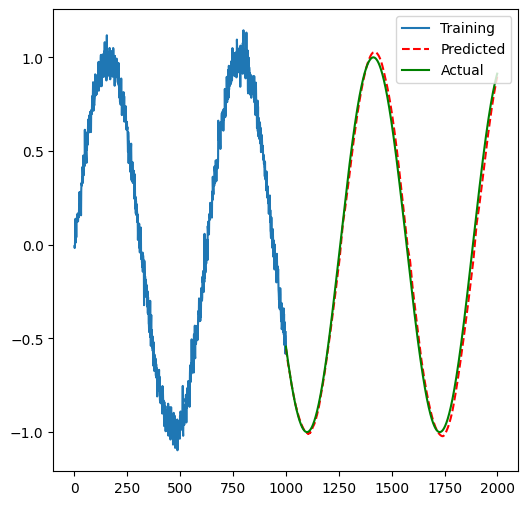

In [8]:
# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
plt.legend()